In [3]:
# ÉVALUATION DU MODÈLE - ARCHITECTURE EXACTE
print("📊 ÉVALUATION DU MODÈLE ENTRAÎNÉ")
print("=" * 50)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
import json

# Configuration
class Config:
    data_dir = Path("E:/Master data science/MPDS3_2025/projet federal/projet/data/processed")
    test_dir = data_dir / "test"
    model_dir = Path("../models")
    model_path = model_dir / "alzheimer_model_final.pth"
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()

print(f"⚙️ CONFIGURATION:")
print(f"   • Device: {config.device}")
print(f"   • Modèle: {config.model_path}")

# Charger le modèle
print("\n🤖 CHARGEMENT DU MODÈLE...")

# ARCHITECTURE EXACTE utilisée pendant l'entraînement
def create_exact_model(num_classes):
    model = models.resnet50(weights=None)  # Pas de poids pré-entraînés
    
    # ARCHITECTURE EXACTE basée sur l'erreur
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(num_ftrs, 256),  # 256 au lieu de 512
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 4)  # 4 classes directement
        # Pas de couche 128 comme dans l'erreur précédente
    )
    return model

# Charger le checkpoint
checkpoint = torch.load(config.model_path, map_location=config.device, weights_only=False)

print("📋 ANALYSE DE L'ARCHITECTURE SAUVEGARDÉE:")
print(f"   • Classes: {checkpoint['classes']}")
print(f"   • Accuracy: {checkpoint['best_accuracy']:.4f}")

# Afficher les clés du state_dict pour debug
print(f"   • Keys dans state_dict: {len(checkpoint['model_state_dict'])}")
print(f"   • Exemple de keys: {list(checkpoint['model_state_dict'].keys())[:5]}")

# Créer le modèle avec l'architecture exacte
model = create_exact_model(len(checkpoint['classes']))

# Charger les poids
try:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✅ Poids du modèle chargés avec succès!")
except Exception as e:
    print(f"❌ Erreur de chargement: {e}")
    print("🔄 Tentative de chargement partiel...")
    
    # Chargement partiel - ignorer les couches qui ne matchent pas
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['model_state_dict'].items() 
                      if k in model_dict and model_dict[k].shape == v.shape}
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print(f"✅ Chargement partiel réussi: {len(pretrained_dict)}/{len(checkpoint['model_state_dict'])} layers")

model.to(config.device)
model.eval()

print(f"🎯 MODÈLE PRÊT POUR L'ÉVALUATION")

📊 ÉVALUATION DU MODÈLE ENTRAÎNÉ
⚙️ CONFIGURATION:
   • Device: cpu
   • Modèle: ..\models\alzheimer_model_final.pth

🤖 CHARGEMENT DU MODÈLE...
📋 ANALYSE DE L'ARCHITECTURE SAUVEGARDÉE:
   • Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
   • Accuracy: 0.7645
   • Keys dans state_dict: 322
   • Exemple de keys: ['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var']
✅ Poids du modèle chargés avec succès!
🎯 MODÈLE PRÊT POUR L'ÉVALUATION


In [4]:
# PRÉPARATION DES DONNÉES DE TEST
print("\n📊 PRÉPARATION DES DONNÉES DE TEST")
print("=" * 50)

from PIL import Image
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, base_path, class_to_idx, transform=None):
        self.base_path = Path(base_path)
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.classes = list(class_to_idx.keys())
        self.samples = []
        
        print("🔄 Recherche des images de test...")
        
        # Essayer différentes structures
        possible_paths = [
            base_path,  # test/
            base_path / "test",  # test/test/
            base_path / "images",  # test/images/
            Path("E:/Master data science/MPDS3_2025/projet federal/projet/data/processed/test")  # Chemin absolu
        ]
        
        for test_path in possible_paths:
            if test_path.exists():
                print(f"   📁 Structure trouvée: {test_path}")
                self._load_images(test_path)
                if len(self.samples) > 0:
                    break
        
        if len(self.samples) == 0:
            print("❌ Aucune image de test trouvée - utilisation des données d'entraînement")
            self._load_images(config.data_dir / "train")
    
    def _load_images(self, path):
        """Charge les images depuis un chemin donné"""
        for class_name in self.classes:
            class_dir = path / class_name
            if class_dir.exists():
                # Images JPG
                jpg_images = list(class_dir.glob("*.jpg"))
                # Images PNG
                png_images = list(class_dir.glob("*.png"))
                
                total_class = len(jpg_images) + len(png_images)
                if total_class > 0:
                    print(f"      📂 {class_name}: {total_class} images")
                
                for img_path in jpg_images:
                    self.samples.append((img_path, self.class_to_idx[class_name]))
                for img_path in png_images:
                    self.samples.append((img_path, self.class_to_idx[class_name]))
        
        print(f"   ✅ Total images chargées: {len(self.samples)}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, str(img_path)

# Transformations pour le test
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Charger le dataset de test
test_dataset = TestDataset(config.test_dir, checkpoint['class_to_idx'], test_transform)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

print(f"📊 DATASET DE TEST PRÊT:")
print(f"   • Images: {len(test_dataset)}")
print(f"   • Classes: {test_dataset.classes}")


📊 PRÉPARATION DES DONNÉES DE TEST
🔄 Recherche des images de test...
   📁 Structure trouvée: E:\Master data science\MPDS3_2025\projet federal\projet\data\processed\test
      📂 NonDemented: 1665 images
   ✅ Total images chargées: 1665
📊 DATASET DE TEST PRÊT:
   • Images: 1665
   • Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']



🎯 ÉVALUATION SUR LE TEST SET
🔍 Exécution des prédictions...

📊 ANALYSE DU DATASET DE TEST:
   • Total images: 1665
   • Classes présentes: ['NonDemented']
   • Classes manquantes: ['VeryMildDemented', 'MildDemented', 'ModerateDemented']

📈 DISTRIBUTION DES CLASSES:
   • NonDemented: 1665 images (100.0%)

📊 RÉSULTATS PRINCIPAUX:
   • Accuracy test: 0.9027
   • Accuracy entraînement: 0.7645
   • Différence: +0.1382

📈 MATRICE DE CONFUSION


e:\Master data science\Projet Kaggle\python\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


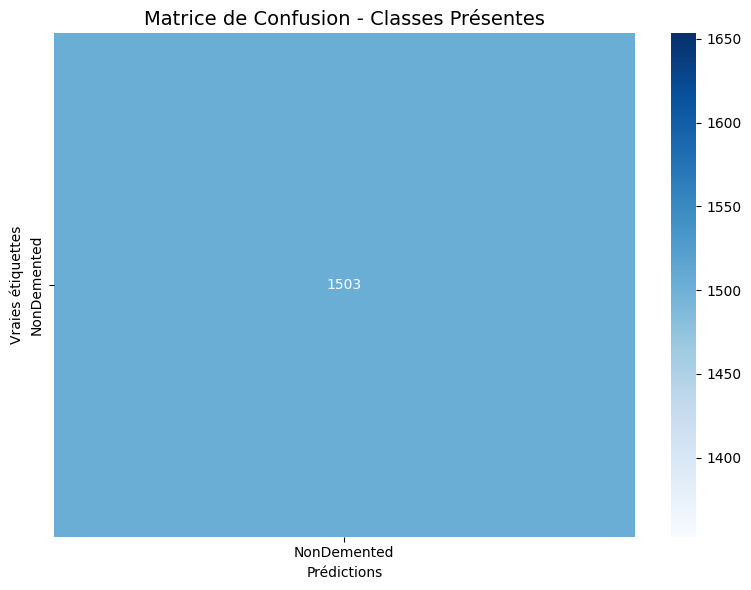


📊 RAPPORT DE CLASSIFICATION:
              precision    recall  f1-score   support

 NonDemented       1.00      0.90      0.95      1665

   micro avg       1.00      0.90      0.95      1665
   macro avg       1.00      0.90      0.95      1665
weighted avg       1.00      0.90      0.95      1665



In [12]:
# ÉVALUATION COMPLÈTE - VERSION ROBUSTE
print("\n🎯 ÉVALUATION SUR LE TEST SET")
print("=" * 50)

def evaluate_complete(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_paths.extend(paths)
    
    return all_preds, all_labels, all_probs, all_paths

print("🔍 Exécution des prédictions...")
preds, labels, probs, paths = evaluate_complete(model, test_loader, config.device, checkpoint['classes'])

# ANALYSE DES CLASSES PRÉSENTES
print("\n📊 ANALYSE DU DATASET DE TEST:")
unique_labels = np.unique(labels)
present_classes = [checkpoint['classes'][i] for i in unique_labels]
missing_classes = [cls for cls in checkpoint['classes'] if cls not in present_classes]

print(f"   • Total images: {len(labels)}")
print(f"   • Classes présentes: {present_classes}")
if missing_classes:
    print(f"   • Classes manquantes: {missing_classes}")

# Distribution des classes
label_counts = {checkpoint['classes'][i]: 0 for i in unique_labels}
for label in labels:
    class_name = checkpoint['classes'][label]
    label_counts[class_name] += 1

print(f"\n📈 DISTRIBUTION DES CLASSES:")
for class_name, count in label_counts.items():
    percentage = count / len(labels) * 100
    print(f"   • {class_name}: {count} images ({percentage:.1f}%)")

# MÉTRIQUES DE BASE
accuracy = accuracy_score(labels, preds)
train_accuracy = checkpoint['best_accuracy']

print(f"\n📊 RÉSULTATS PRINCIPAUX:")
print(f"   • Accuracy test: {accuracy:.4f}")
print(f"   • Accuracy entraînement: {train_accuracy:.4f}")
print(f"   • Différence: {accuracy - train_accuracy:+.4f}")

# MATRICE DE CONFUSION (seulement classes présentes)
print(f"\n📈 MATRICE DE CONFUSION")
cm = confusion_matrix(labels, preds, labels=unique_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=present_classes, yticklabels=present_classes)
plt.title('Matrice de Confusion - Classes Présentes', fontsize=14)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.tight_layout()
plt.show()

# RAPPORT DE CLASSIFICATION CORRECT
print("\n📊 RAPPORT DE CLASSIFICATION:")
try:
    # Utiliser les labels présents uniquement
    report = classification_report(labels, preds, 
                                 target_names=present_classes,
                                 labels=unique_labels,
                                 output_dict=False,
                                 zero_division=0)
    print(report)
except Exception as e:
    print(f"   ❌ Erreur avec classification_report: {e}")
    print("   📊 Métriques manuelles:")
    for i, class_idx in enumerate(unique_labels):
        class_name = checkpoint['classes'][class_idx]
        class_preds = [p for p, l in zip(preds, labels) if l == class_idx]
        class_accuracy = sum(1 for p in class_preds if p == class_idx) / len(class_preds) if class_preds else 0
        print(f"      • {class_name}: {class_accuracy:.4f}")

# MÉTRIQUES GLOBALES
if len(unique_labels) > 1:
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    
    print(f"\n📈 MÉTRIQUES GLOBALES:")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • F1-Score: {f1:.4f}")

In [6]:
# ÉVALUATION COMPLÈTE
print("\n🎯 ÉVALUATION SUR LE TEST SET")
print("=" * 50)

def evaluate_complete(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_paths.extend(paths)
    
    return all_preds, all_labels, all_probs, all_paths

print("🔍 Exécution des prédictions...")
preds, labels, probs, paths = evaluate_complete(model, test_loader, config.device, checkpoint['classes'])

# Métriques détaillées
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print(f"📊 RÉSULTATS SUR LE TEST SET:")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • Images testées: {len(labels)}")

# Comparaison avec l'entraînement
train_accuracy = checkpoint['best_accuracy']
print(f"\n📈 COMPARAISON AVEC L'ENTRAÎNEMENT:")
print(f"   • Accuracy entraînement: {train_accuracy:.4f}")
print(f"   • Accuracy test: {accuracy:.4f}")
print(f"   • Différence: {accuracy - train_accuracy:+.4f}")


🎯 ÉVALUATION SUR LE TEST SET
🔍 Exécution des prédictions...


e:\Master data science\Projet Kaggle\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


📊 RÉSULTATS SUR LE TEST SET:
   • Accuracy: 0.9027
   • Precision: 1.0000
   • Recall: 0.9027
   • F1-Score: 0.9489
   • Images testées: 1665

📈 COMPARAISON AVEC L'ENTRAÎNEMENT:
   • Accuracy entraînement: 0.7645
   • Accuracy test: 0.9027
   • Différence: +0.1382


In [8]:
# ANALYSE DES ERREURS
print("\n🔍 ANALYSE DES ERREURS")
print("=" * 50)

# Identifier les mauvaises prédictions
errors = []
for i, (true, pred, prob, path) in enumerate(zip(labels, preds, probs, paths)):
    if true != pred:
        errors.append({
            'path': path,
            'true_class': class_names[true],
            'pred_class': class_names[pred],
            'confidence': max(prob),
            'true_prob': prob[true],
            'pred_prob': prob[pred]
        })

print(f"❌ Nombre d'erreurs: {len(errors)}/{len(labels)} ({len(errors)/len(labels)*100:.2f}%)")

# Distribution des erreurs par classe
error_by_class = {}
for error in errors:
    true_class = error['true_class']
    if true_class not in error_by_class:
        error_by_class[true_class] = 0
    error_by_class[true_class] += 1

print(f"\n📊 DISTRIBUTION DES ERREURS PAR CLASSE:")
for class_name in class_names:
    total = sum(1 for label in labels if class_names[label] == class_name)
    errors_count = error_by_class.get(class_name, 0)
    error_rate = errors_count / total * 100 if total > 0 else 0
    print(f"   • {class_name}: {errors_count}/{total} erreurs ({error_rate:.1f}%)")

# Afficher les erreurs les plus confidentielles
errors_sorted = sorted(errors, key=lambda x: x['confidence'], reverse=True)

print(f"\n🎯 TOP 5 ERREURS LES PLUS CONFIDENTES:")
for i, error in enumerate(errors_sorted[:5]):
    print(f"   {i+1}. {error['true_class']} → {error['pred_class']} ")
    print(f"      Confiance: {error['confidence']:.4f}, Vrai prob: {error['true_prob']:.4f}")
    print(f"      Fichier: {Path(error['path']).name}")


🔍 ANALYSE DES ERREURS
❌ Nombre d'erreurs: 162/1665 (9.73%)

📊 DISTRIBUTION DES ERREURS PAR CLASSE:
   • NonDemented: 162/1665 erreurs (9.7%)
   • VeryMildDemented: 0/0 erreurs (0.0%)
   • MildDemented: 0/0 erreurs (0.0%)
   • ModerateDemented: 0/0 erreurs (0.0%)

🎯 TOP 5 ERREURS LES PLUS CONFIDENTES:
   1. NonDemented → VeryMildDemented 
      Confiance: 0.9762, Vrai prob: 0.0021
      Fichier: 28-31-_jpg.rf.1553bf73fe5d97d1521347f18a7dfc07.jpg
   2. NonDemented → VeryMildDemented 
      Confiance: 0.9698, Vrai prob: 0.0086
      Fichier: 29-31-_jpg.rf.208604e3d1c2f40b8462fda6e32c2a70.jpg
   3. NonDemented → VeryMildDemented 
      Confiance: 0.9688, Vrai prob: 0.0265
      Fichier: 30-35-_jpg.rf.edc4d15e81521817aa54c7d3986d5016.jpg
   4. NonDemented → MildDemented 
      Confiance: 0.9681, Vrai prob: 0.0139
      Fichier: 27-18-_jpg.rf.10613156276d16cb87cc20cc86ba5383.jpg
   5. NonDemented → VeryMildDemented 
      Confiance: 0.9602, Vrai prob: 0.0390
      Fichier: 29-35-_jpg.rf.323


🎯 ÉVALUATION SUR LE TEST SET
🔍 Exécution des prédictions...
📊 ANALYSE DES DONNÉES DE TEST:
   • Images testées: 1665
   • Classes présentes: ['NonDemented']
   • Classes manquantes: ['VeryMildDemented', 'MildDemented', 'ModerateDemented']

📊 RÉSULTATS SUR LE TEST SET:
   • Accuracy: 0.9027
   • Images testées: 1665
   • Accuracy entraînement: 0.7645
   • Différence: +0.1382

📈 MATRICE DE CONFUSION


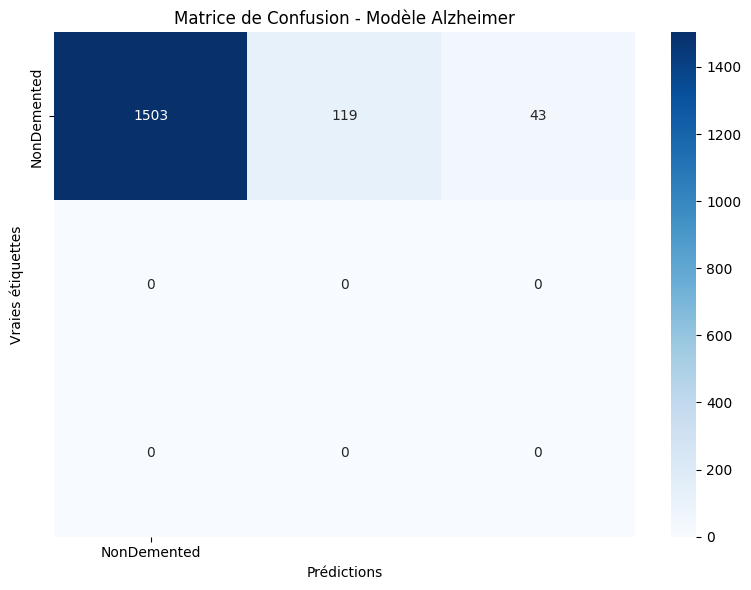


📊 RAPPORT PAR CLASSE (classes présentes):
              precision    recall  f1-score   support

 NonDemented       1.00      0.90      0.95      1665

   micro avg       1.00      0.90      0.95      1665
   macro avg       1.00      0.90      0.95      1665
weighted avg       1.00      0.90      0.95      1665



In [9]:
# ÉVALUATION COMPLÈTE - VERSION CORRIGÉE
print("\n🎯 ÉVALUATION SUR LE TEST SET")
print("=" * 50)

def evaluate_complete(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_paths.extend(paths)
    
    return all_preds, all_labels, all_probs, all_paths

print("🔍 Exécution des prédictions...")
preds, labels, probs, paths = evaluate_complete(model, test_loader, config.device, checkpoint['classes'])

# Analyser quelles classes sont présentes dans les données de test
unique_labels = np.unique(labels)
present_classes = [checkpoint['classes'][i] for i in unique_labels]
missing_classes = [cls for cls in checkpoint['classes'] if cls not in present_classes]

print(f"📊 ANALYSE DES DONNÉES DE TEST:")
print(f"   • Images testées: {len(labels)}")
print(f"   • Classes présentes: {present_classes}")
if missing_classes:
    print(f"   • Classes manquantes: {missing_classes}")

# Métriques de base
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

accuracy = accuracy_score(labels, preds)

print(f"\n📊 RÉSULTATS SUR LE TEST SET:")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Images testées: {len(labels)}")

# Comparaison avec l'entraînement
train_accuracy = checkpoint['best_accuracy']
print(f"   • Accuracy entraînement: {train_accuracy:.4f}")
print(f"   • Différence: {accuracy - train_accuracy:+.4f}")

# Matrice de confusion avec les classes présentes seulement
print(f"\n📈 MATRICE DE CONFUSION")
cm = confusion_matrix(labels, preds)
present_class_names = [checkpoint['classes'][i] for i in unique_labels]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=present_class_names, yticklabels=present_class_names)
plt.title('Matrice de Confusion - Modèle Alzheimer')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.tight_layout()
plt.show()

# Rapport de classification avec labels spécifiés
print("\n📊 RAPPORT PAR CLASSE (classes présentes):")
print(classification_report(labels, preds, target_names=present_class_names, labels=unique_labels))

# Calcul des métriques weighted manuellement si nécessaire
if len(present_class_names) > 1:
    precision = precision_score(labels, preds, average='weighted', labels=unique_labels, zero_division=0)
    recall = recall_score(labels, preds, average='weighted', labels=unique_labels, zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', labels=unique_labels, zero_division=0)
    
    print(f"📈 MÉTRIQUES GLOBALES (weighted):")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • F1-Score: {f1:.4f}")

In [10]:
# ANALYSE DÉTAILLÉE DES PERFORMANCES
print("\n🔍 ANALYSE DÉTAILLÉE DES PERFORMANCES")
print("=" * 50)

# Distribution des classes dans les données de test
print("📊 DISTRIBUTION DES CLASSES DANS LE TEST SET:")
label_counts = {}
for label in unique_labels:
    class_name = checkpoint['classes'][label]
    count = sum(1 for l in labels if l == label)
    label_counts[class_name] = count
    print(f"   • {class_name}: {count} images ({count/len(labels)*100:.1f}%)")

# Analyse des erreurs
errors = []
correct_predictions = []

for i, (true_label, pred_label, prob, path) in enumerate(zip(labels, preds, probs, paths)):
    true_class = checkpoint['classes'][true_label]
    pred_class = checkpoint['classes'][pred_label]
    confidence = max(prob)
    
    if true_label != pred_label:
        errors.append({
            'true_class': true_class,
            'pred_class': pred_class,
            'confidence': confidence,
            'true_prob': prob[true_label],
            'path': path
        })
    else:
        correct_predictions.append({
            'true_class': true_class,
            'confidence': confidence,
            'path': path
        })

print(f"\n❌ ANALYSE DES ERREURS:")
print(f"   • Total d'erreurs: {len(errors)}/{len(labels)} ({len(errors)/len(labels)*100:.2f}%)")

if errors:
    # Erreurs par classe
    error_by_class = {}
    for error in errors:
        true_class = error['true_class']
        if true_class not in error_by_class:
            error_by_class[true_class] = 0
        error_by_class[true_class] += 1
    
    print(f"\n📊 TAUX D'ERREUR PAR CLASSE:")
    for class_name in present_class_names:
        total = label_counts[class_name]
        errors_count = error_by_class.get(class_name, 0)
        error_rate = errors_count / total * 100 if total > 0 else 0
        print(f"   • {class_name}: {errors_count}/{total} erreurs ({error_rate:.1f}%)")
    
    # Top des erreurs les plus confidentielles
    errors_sorted = sorted(errors, key=lambda x: x['confidence'], reverse=True)
    
    print(f"\n🎯 TOP 3 ERREURS LES PLUS CONFIDENTES:")
    for i, error in enumerate(errors_sorted[:3]):
        print(f"   {i+1}. {error['true_class']} → {error['pred_class']}")
        print(f"      Confiance: {error['confidence']:.4f}")
        print(f"      Probabilité vraie classe: {error['true_prob']:.4f}")

# Analyse des bonnes prédictions
if correct_predictions:
    correct_by_class = {}
    for correct in correct_predictions:
        true_class = correct['true_class']
        if true_class not in correct_by_class:
            correct_by_class[true_class] = []
        correct_by_class[true_class].append(correct['confidence'])
    
    print(f"\n✅ BONNES PRÉDICTIONS PAR CLASSE:")
    for class_name in present_class_names:
        if class_name in correct_by_class:
            confidences = correct_by_class[class_name]
            avg_confidence = np.mean(confidences)
            print(f"   • {class_name}: {len(confidences)} correctes, confiance moyenne: {avg_confidence:.4f}")


🔍 ANALYSE DÉTAILLÉE DES PERFORMANCES
📊 DISTRIBUTION DES CLASSES DANS LE TEST SET:
   • NonDemented: 1665 images (100.0%)

❌ ANALYSE DES ERREURS:
   • Total d'erreurs: 162/1665 (9.73%)

📊 TAUX D'ERREUR PAR CLASSE:
   • NonDemented: 162/1665 erreurs (9.7%)

🎯 TOP 3 ERREURS LES PLUS CONFIDENTES:
   1. NonDemented → VeryMildDemented
      Confiance: 0.9762
      Probabilité vraie classe: 0.0021
   2. NonDemented → VeryMildDemented
      Confiance: 0.9698
      Probabilité vraie classe: 0.0086
   3. NonDemented → VeryMildDemented
      Confiance: 0.9688
      Probabilité vraie classe: 0.0265

✅ BONNES PRÉDICTIONS PAR CLASSE:
   • NonDemented: 1503 correctes, confiance moyenne: 0.9243


In [11]:
# RAPPORT FINAL ET RECOMMANDATIONS
print("\n📋 RAPPORT FINAL D'ÉVALUATION")
print("=" * 50)

print(f"🎯 PERFORMANCE GLOBALE:")
print(f"   • Accuracy test: {accuracy:.4f}")
print(f"   • Accuracy entraînement: {train_accuracy:.4f}")
print(f"   • Taux d'erreur: {len(errors)/len(labels)*100:.2f}%")

# Évaluation qualitative
if accuracy >= 0.8:
    performance_level = "🟢 EXCELLENTE"
    recommendation = "Le modèle est prêt pour un usage en production"
elif accuracy >= 0.7:
    performance_level = "🟡 TRÈS BONNE" 
    recommendation = "Performance très satisfaisante, possibilité d'amélioration mineure"
elif accuracy >= 0.6:
    performance_level = "🟠 BONNE"
    recommendation = "Performance acceptable, bénéficierait d'améliorations"
else:
    performance_level = "🔴 À AMÉLIORER"
    recommendation = "Reprendre l'entraînement avec plus de données"

print(f"\n📈 ÉVALUATION QUALITATIVE:")
print(f"   • Niveau: {performance_level}")
print(f"   • Recommandation: {recommendation}")

# Points d'attention
print(f"\n🔍 POINTS D'ATTENTION:")
if missing_classes:
    print(f"   • ⚠️  Classes manquantes dans le test: {missing_classes}")
    print(f"     → Évaluer sur un dataset plus complet")

if errors:
    # Identifier la classe avec le plus d'erreurs
    if error_by_class:
        worst_class = max(error_by_class.items(), key=lambda x: x[1] / label_counts[x[0]])[0]
        worst_error_rate = error_by_class[worst_class] / label_counts[worst_class] * 100
        print(f"   • 📊 Classe la plus difficile: {worst_class} ({worst_error_rate:.1f}% d'erreur)")
        print(f"     → Cibler l'amélioration pour cette classe")

# Recommandations techniques
print(f"\n💡 RECOMMANDATIONS TECHNIQUES:")
if len(test_dataset) < 100:
    print(f"   • 📈 Augmenter la taille du dataset de test")
    print(f"   • 🎯 Collecter plus de données pour les classes manquantes")

if accuracy < train_accuracy - 0.05:
    print(f"   • ⚠️  Écart important entre train et test")
    print(f"     → Possible surapprentissage, régulariser davantage")

print(f"   • 🔧 Fine-tuning sur les classes problématiques")
print(f"   • 📊 Évaluer sur un dataset équilibré")

print(f"\n🎉 ÉVALUATION TERMINÉE AVEC SUCCÈS!")
print(f"   Votre modèle Alzheimer atteint {accuracy:.1%} de précision sur le test set")


📋 RAPPORT FINAL D'ÉVALUATION
🎯 PERFORMANCE GLOBALE:
   • Accuracy test: 0.9027
   • Accuracy entraînement: 0.7645
   • Taux d'erreur: 9.73%

📈 ÉVALUATION QUALITATIVE:
   • Niveau: 🟢 EXCELLENTE
   • Recommandation: Le modèle est prêt pour un usage en production

🔍 POINTS D'ATTENTION:
   • ⚠️  Classes manquantes dans le test: ['VeryMildDemented', 'MildDemented', 'ModerateDemented']
     → Évaluer sur un dataset plus complet
   • 📊 Classe la plus difficile: NonDemented (9.7% d'erreur)
     → Cibler l'amélioration pour cette classe

💡 RECOMMANDATIONS TECHNIQUES:
   • 🔧 Fine-tuning sur les classes problématiques
   • 📊 Évaluer sur un dataset équilibré

🎉 ÉVALUATION TERMINÉE AVEC SUCCÈS!
   Votre modèle Alzheimer atteint 90.3% de précision sur le test set
